In [42]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
%matplotlib inline

import sys

sys.path.append("..")

import GanUtils as utils
import GaussianMixtureUtils as GMutils

sys.path.append("../DiscriminativeNN")

import DiscGaussianMixture5Layers as disc

sys.path.append("../GenerativeNN")

import GenGaussianMixture5Layers as gen

manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7511


In [43]:
batchSize = 64
nz = 10
nc = 2 # Number of outputs
ndf = 10
ngf = 10
niter = 20
nElements = 10000
lr = 0.00005
beta1 = 0.5
n_critic = 5 # Training more the discriminator

nff = 10
c = 0.01 # clip

In [44]:
netG = torch.nn.Sequential(
    torch.nn.Linear(nz, ngf),
    torch.nn.ReLU(),
    torch.nn.Linear(ngf, nc),
    torch.nn.Tanh()
)


netD = torch.nn.Sequential(
    torch.nn.Linear(nc, ndf),
    torch.nn.ReLU(),
    torch.nn.Linear(ndf, 1),
)

In [45]:
optimizerG = optim.RMSprop(netG.parameters(), lr = lr)
optimizerD = optim.RMSprop(netD.parameters(), lr = lr)

In [46]:
# Might mistake here
input = torch.FloatTensor(batchSize, 2)
noise = torch.FloatTensor(batchSize, nz)
fixed_noise = torch.FloatTensor(batchSize, nz).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

[0/21][0/10000] Loss_D: -0.00001447 Loss_G: -0.0004 D(G(z)): 0.0004
[0/21][1000/10000] Loss_D: -0.00003749 Loss_G: -0.0006 D(G(z)): 0.0006


KeyboardInterrupt: 

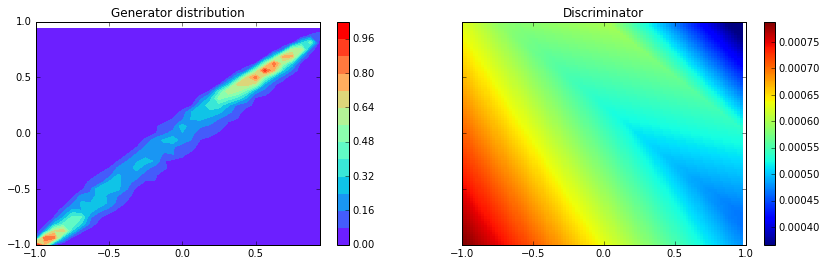

In [49]:
print_every = nElements / 10
reload(GMutils)
for epoch in range(niter):
    for i in range(nElements):
        ############################
        # (1) Update D network
        ###########################
        # train with real
        for t in range(n_critic):
            netD.zero_grad()
            
            ## Real 
            real_cpu = GMutils.sample(batchSize)
            batch_size = real_cpu.size(0)
            input.data.resize_(real_cpu.size()).copy_(real_cpu)
            
            output_real = netD(input)
            
            ## Fake
            noise.data.resize_(batch_size, nz)
            noise.data.normal_(0, 1)
            fake = netG(noise).detach()
            
            output_fake = netD(fake)
            
            errD = - torch.mean(output_real) + torch.mean(output_fake)
            errD.backward()
            optimizerD.step()
                        
            ## Clip
            for p in netD.parameters():
                p.data.clamp_(-c, c)

        ############################
        # (2) Update G network
        ###########################
        
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        noise.data.normal_(0, 1)
        fake = netG(noise)
        output = netD(fake)
        errG = - torch.mean(output)
        errG.backward()
        
        D_G_z2 = output.data.mean()
        
        optimizerG.step()
        
        if i % print_every == 0:
            GMutils.plot_duo_heat_map(utils.sample_G(netG, nz, 10000), netD)
            print('[%d/%d][%d/%d] Loss_D: %.8f Loss_G: %.4f D(G(z)): %.4f'
              % (epoch, niter + 1, i, nElements,
                 errD.data.sum(), errG.data[0], D_G_z2))

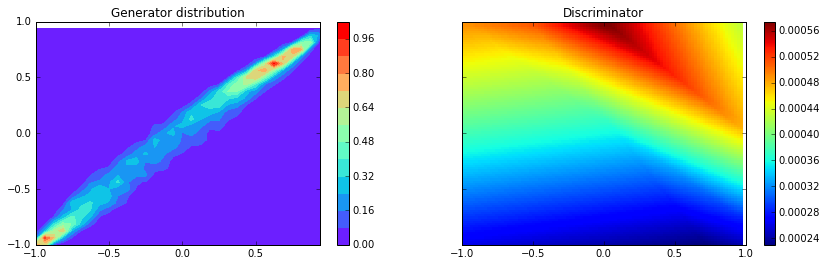

In [48]:
GMutils.plot_duo_heat_map(utils.sample_G(netG, nz, 10000), netD)